<a href="https://colab.research.google.com/github/DrakeData/Bankruptcy_Prediction/blob/main/bankruptcy_pred_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: Company Bankruptcy Prediction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
from sklearn.naive_bayes import GaussianNB

## Ingest
Donwloading the data from Kaggle's API

In [2]:
! pip install kaggle

In [3]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! cp './drive/MyDrive/Colab Notebooks/API Keys/kaggle.json' ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download fedesoriano/company-bankruptcy-prediction

company-bankruptcy-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
! unzip company-bankruptcy-prediction

Archive:  company-bankruptcy-prediction.zip
replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data.csv                


### Import Data

In [8]:
df = pd.read_csv('/content/data.csv')
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.368913,0.011543,0.005348,0.629631,0.021248,0.207516,0.792484,0.005100,..

## EDA

In [9]:
df.shape

(6819, 96)

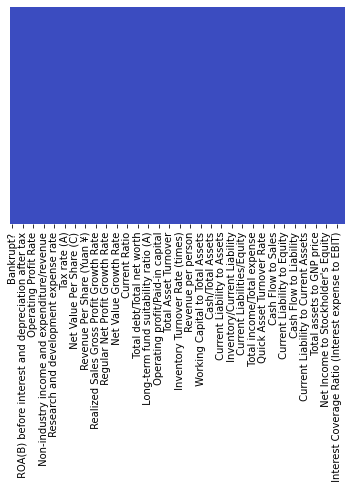

In [10]:
# Heatmap check for nulls in train set
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='coolwarm');

In [11]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [12]:
# Check for duplicates
print(f'Number of duplicates values : {df.duplicated().sum()}')

Number of duplicates values : 0


In [13]:
# Check bankrupt (Y/N) column
df['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

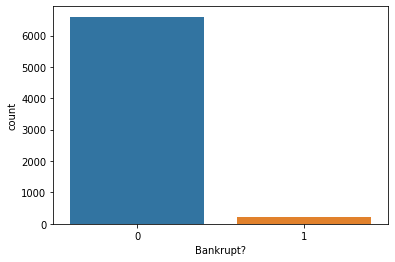

In [14]:
sns.countplot(x='Bankrupt?', data=df);

Looks like there are a high amount of 'No' compared to 'Yes' in the 'Bankrupt?' column, which means that this data set is highly unbalanced.

### Rebalence data

In [15]:
# Separate majority and minority classes
df_majority = df[df['Bankrupt?']==0]
df_minority = df[df['Bankrupt?']==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=6599,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled['Bankrupt?'].value_counts()

1    6599
0    6599
Name: Bankrupt?, dtype: int64

In [16]:
df_upsampled.shape

(13198, 96)

### Check for outliers

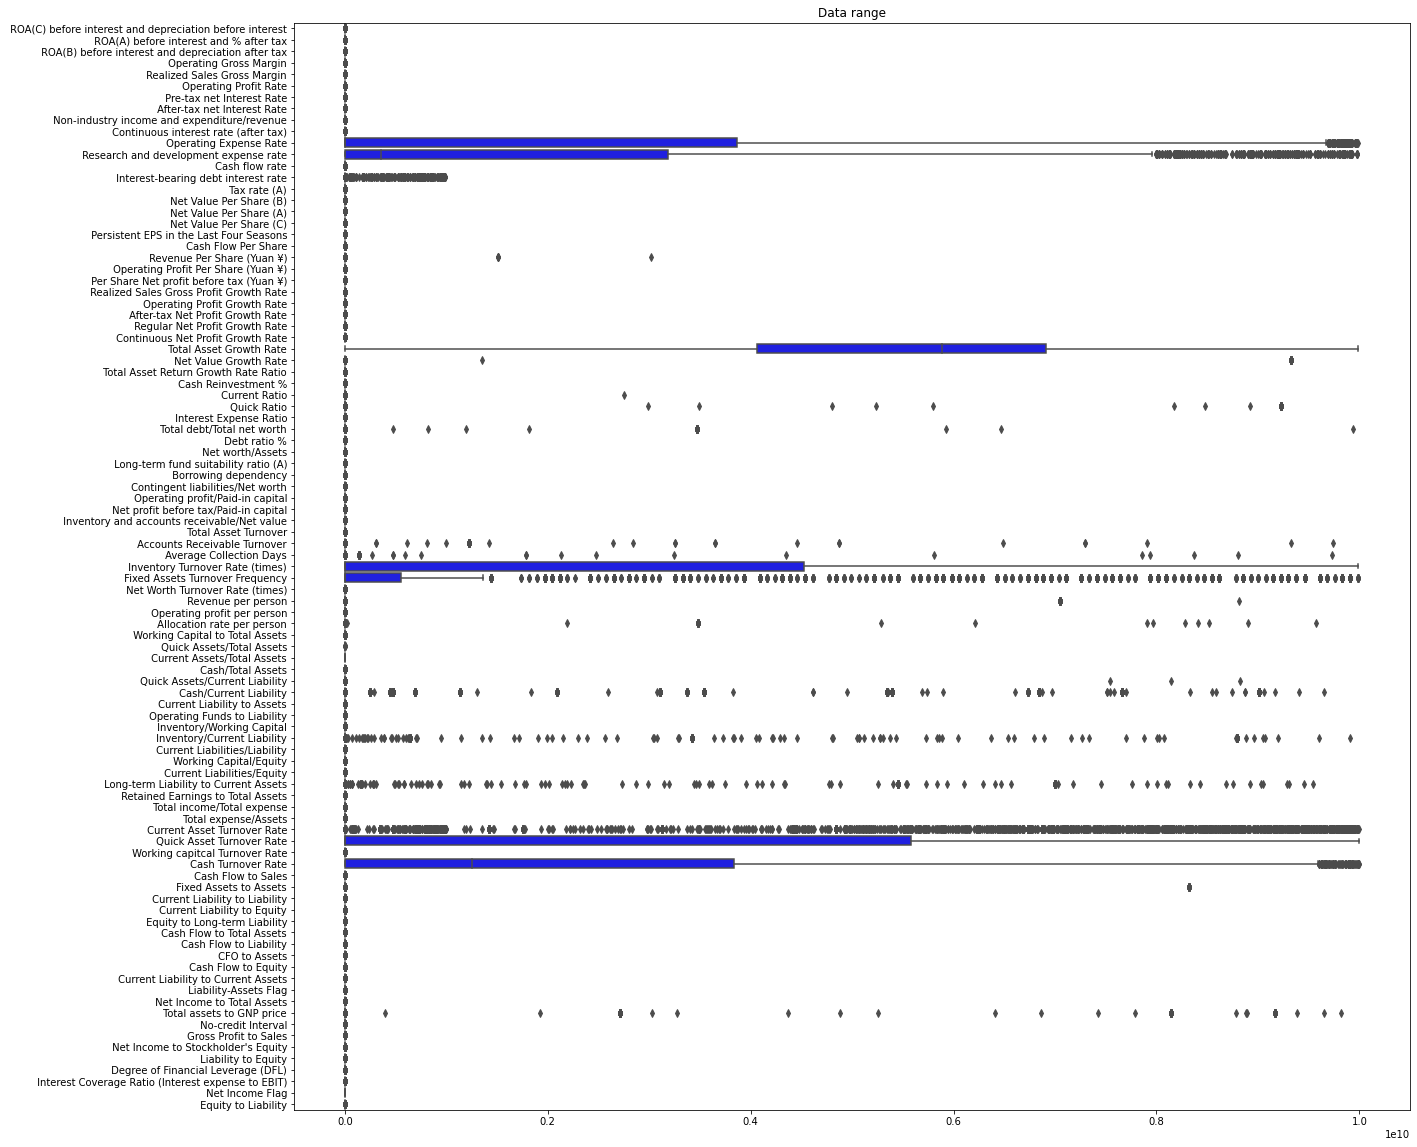

In [17]:
plt.figure(figsize=(20,20))
sns.boxplot(data=df_upsampled.drop(['Bankrupt?'], axis=1), orient='h', color='blue')
plt.title('Data range')
plt.show()

Code caps the numeric columns by looking at the quantile values between .01 and .99 and replaces the value to the closest quantile in the range.

In [18]:
pd.options.mode.chained_assignment = None  # default='warn'

def cap_data(df):
    for col in df.columns:
        print("capping the ",col)
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([0.01,0.99]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df

final_df = cap_data(df_upsampled)

capping the  Bankrupt?
capping the   ROA(C) before interest and depreciation before interest
capping the   ROA(A) before interest and % after tax
capping the   ROA(B) before interest and depreciation after tax
capping the   Operating Gross Margin
capping the   Realized Sales Gross Margin
capping the   Operating Profit Rate
capping the   Pre-tax net Interest Rate
capping the   After-tax net Interest Rate
capping the   Non-industry income and expenditure/revenue
capping the   Continuous interest rate (after tax)
capping the   Operating Expense Rate
capping the   Research and development expense rate
capping the   Cash flow rate
capping the   Interest-bearing debt interest rate
capping the   Tax rate (A)
capping the   Net Value Per Share (B)
capping the   Net Value Per Share (A)
capping the   Net Value Per Share (C)
capping the   Persistent EPS in the Last Four Seasons
capping the   Cash Flow Per Share
capping the   Revenue Per Share (Yuan ¥)
capping the   Operating Profit Per Share (Yuan

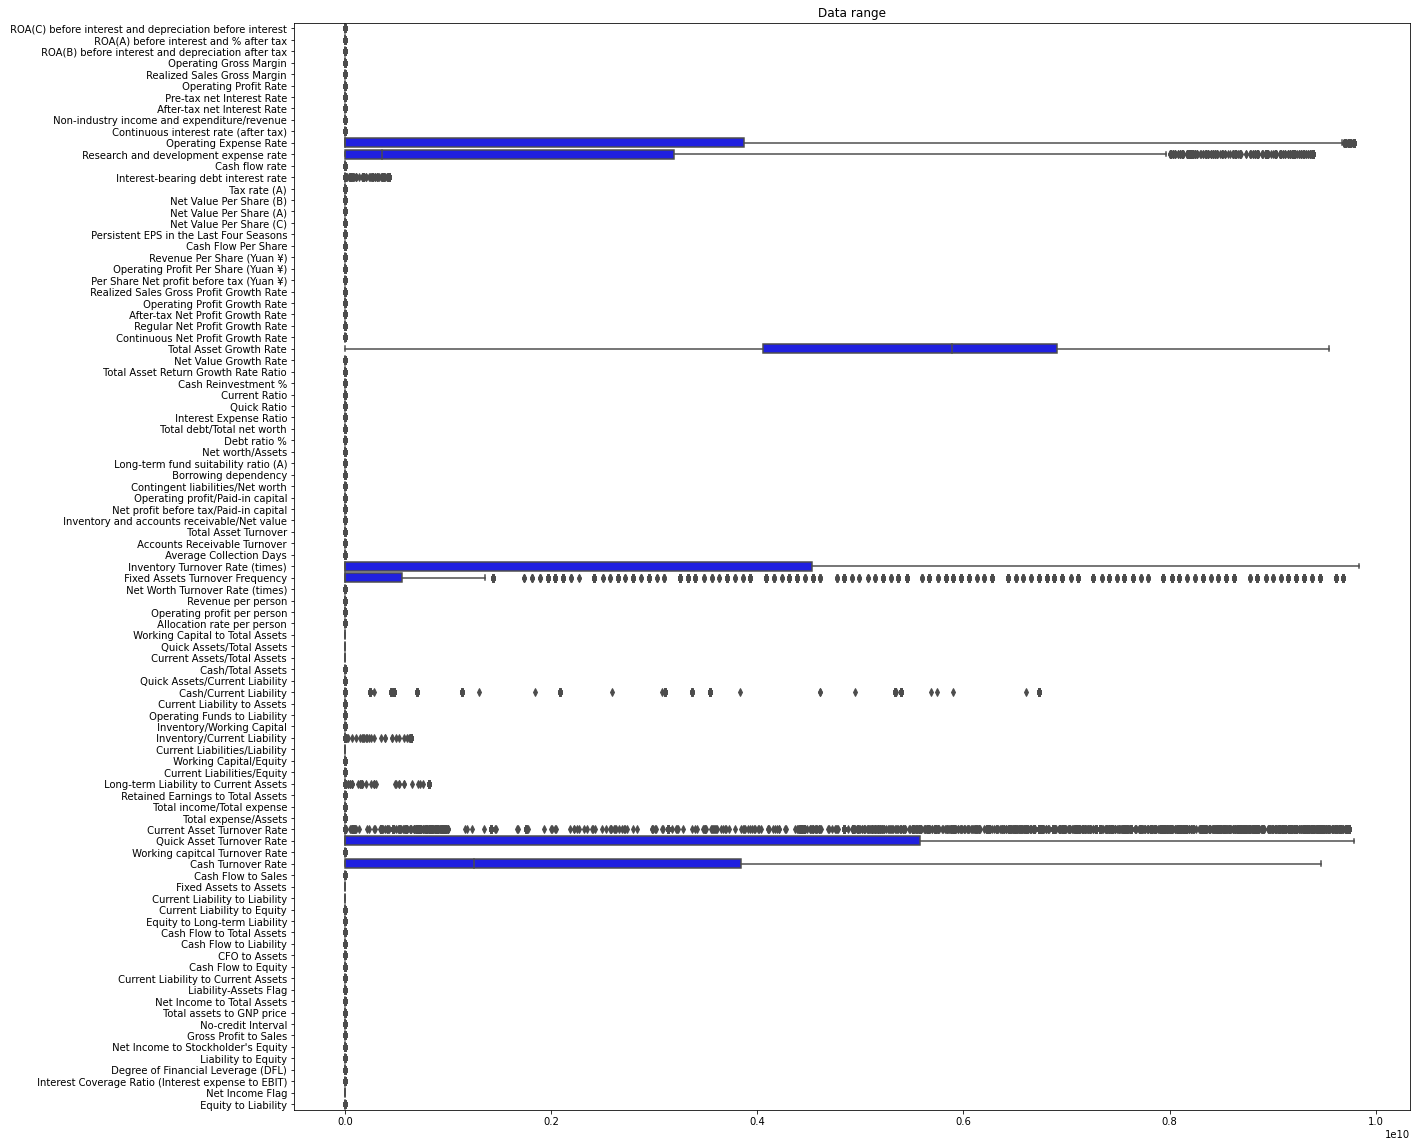

In [19]:
plt.figure(figsize=(20,20))
sns.boxplot(data=final_df.drop(['Bankrupt?'], axis=1), orient='h', color='blue')
plt.title('Data range')
plt.show()

## Modeling

In [20]:
# defining dependent and independent variables
x = final_df.drop('Bankrupt?', axis=1)
y = final_df['Bankrupt?']

In [21]:
# split data into 80% train & 20% test set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                    random_state=0)

### Support Vector Machine (SVM) Model

In [22]:
# Set up model
svc = SVC(kernel='rbf', probability=True)
svc.fit(x_train, y_train)

# Get confusion matrix
y_pred = svc.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(f'Confusion matrix:\n {cm}')

Confusion matrix:
 [[ 934  334]
 [ 251 1121]]


In [23]:
# Check accuracy
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy score = {acc}')
print(f'Classification Report {classification_report(y_test, y_pred)}')

Accuracy score = 0.7784090909090909
Classification Report               precision    recall  f1-score   support

           0       0.79      0.74      0.76      1268
           1       0.77      0.82      0.79      1372

    accuracy                           0.78      2640
   macro avg       0.78      0.78      0.78      2640
weighted avg       0.78      0.78      0.78      2640



Looking at the classification report, the Logistic Regression Model was able to accurately predict 79% of no (0) bankruptcies and 77% yes (1) bankruptcies (seen in the precision column). The overall accuracy of this classification model is around 77.8%.

In [24]:
svc_probs = svc.predict_proba(x_test)
svc_auc = roc_auc_score(y_test, svc_probs[:, 1])
print('Prediction: AUROC = %.3f' % (svc_auc))

Prediction: AUROC = 0.856


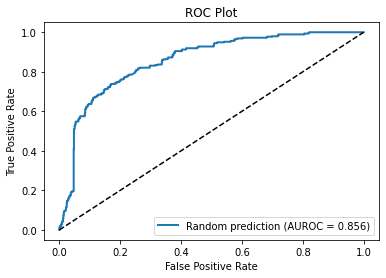

In [25]:
svc_fpr, svc_tpr, _ = roc_curve(y_test, svc_probs[:, 1])

plt.plot(svc_fpr, svc_tpr, linewidth=2, label='Random prediction (AUROC = %0.3f)' % svc_auc)
plt.plot([0,1], [0,1], 'k--')

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [26]:
print(f'Precision score: {precision_score(y_test, y_pred)}')
print(f'Recall score: {recall_score(y_test, y_pred)}')

Precision score: 0.770446735395189
Recall score: 0.8170553935860059


With the precision and recall score being close together, I feel that this model has a good balance of reducing the number of false positives, all while trying to limit the number of false negatives. It’s not perfect, but this is a fair model.

#### Tuning the SVM Model
To try and enhance our SVM model, I will see what changing the kernel type from Radial-basis function (rbf) to the poly algorithm. See [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) for other kernel options for future review.

In [41]:
# Set up model
svc2 = SVC(kernel='poly', probability=True)
svc2.fit(x_train, y_train)

# Get confusion matrix
y_predd = svc2.predict(x_test)
cm = confusion_matrix(y_test, y_predd)
print(f'Confusion matrix:\n {cm}')

Confusion matrix:
 [[ 787  481]
 [ 260 1112]]


In [42]:
# Check accuracy
acc2 = accuracy_score(y_test, y_predd)
print(f'Accuracy score = {acc2}')
print(f'Classification Report {classification_report(y_test, y_predd)}')

Accuracy score = 0.7193181818181819
Classification Report               precision    recall  f1-score   support

           0       0.75      0.62      0.68      1268
           1       0.70      0.81      0.75      1372

    accuracy                           0.72      2640
   macro avg       0.72      0.72      0.71      2640
weighted avg       0.72      0.72      0.72      2640



Compared to the first SVC model, we can already identify that the second model is preforming less. The precision is lower with lower recall, which indicates that the model is not classifying the proper values correctly.

In [43]:
svc_probs2 = svc2.predict_proba(x_test)
svc_auc2 = roc_auc_score(y_test, svc_probs2[:, 1])
print('Prediction: AUROC = %.3f' % (svc_auc2))

Prediction: AUROC = 0.794


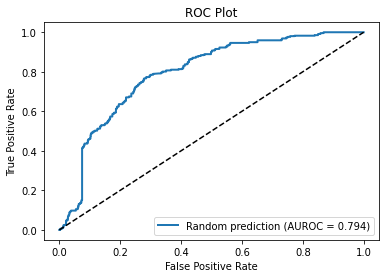

In [44]:
svc_fpr2, svc_tpr2, _ = roc_curve(y_test, svc_probs2[:, 1])

plt.plot(svc_fpr2, svc_tpr2, linewidth=2, label='Random prediction (AUROC = %0.3f)' % svc_auc2)
plt.plot([0,1], [0,1], 'k--')

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [45]:
print(f'Precision score: {precision_score(y_test, y_predd)}')
print(f'Recall score: {recall_score(y_test, y_predd)}')

Precision score: 0.6980539861895794
Recall score: 0.8104956268221575


As expected, the precision and recall scores are worse for the SVM2 model vs the first SVM model. I would suggest not using a poly algorithm and try a different kernel.

#### Testing SVM Regularization Parameter
From [sklearn's documentatoin](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html): The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty. Default = 1.0

In [46]:
# Set up model
svc3 = SVC(kernel='rbf', C=2, probability=True)
svc3.fit(x_train, y_train)

# Get confusion matrix
y_preddd = svc3.predict(x_test)
cm = confusion_matrix(y_test, y_preddd)
print(f'Confusion matrix:\n {cm}')

Confusion matrix:
 [[ 956  312]
 [ 226 1146]]


In [47]:
# Check accuracy
acc3 = accuracy_score(y_test, y_preddd)
print(f'Accuracy score = {acc3}')
print(f'Classification Report {classification_report(y_test, y_preddd)}')

Accuracy score = 0.7962121212121213
Classification Report               precision    recall  f1-score   support

           0       0.81      0.75      0.78      1268
           1       0.79      0.84      0.81      1372

    accuracy                           0.80      2640
   macro avg       0.80      0.79      0.80      2640
weighted avg       0.80      0.80      0.80      2640



The precision and recall score improved from the first SVM model by a couple points. Much better than the second SVM model.

In [48]:
svc3_probs = svc3.predict_proba(x_test)
svc3_auc = roc_auc_score(y_test, svc3_probs[:, 1])
print('Prediction: AUROC = %.3f' % (svc3_auc))

Prediction: AUROC = 0.876


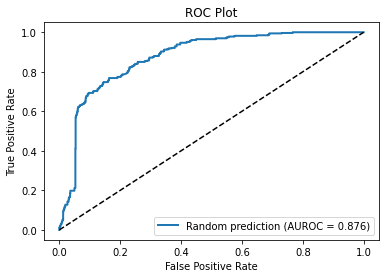

In [51]:
svc_fpr3, svc_tpr3, _ = roc_curve(y_test, svc3_probs[:, 1])

plt.plot(svc_fpr3, svc_tpr3, linewidth=2, label='Random prediction (AUROC = %0.3f)' % svc3_auc)
plt.plot([0,1], [0,1], 'k--')

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [52]:
print(f'Precision score: {precision_score(y_test, y_preddd)}')
print(f'Recall score: {recall_score(y_test, y_preddd)}')

Precision score: 0.7860082304526749
Recall score: 0.8352769679300291


The SVM3 model has improved since the first SVM model just by tuning the C parameter.

### Logistic Regression Model

In [32]:
# Set up model
log_regre = LogisticRegression(max_iter=10000)
log_regre.fit(x_train,y_train)

# Get confusion matrix
lr_probs = log_regre.predict(x_test)
lr_auc = roc_auc_score(y_test, lr_probs)
cm2 = confusion_matrix(y_test, lr_probs)
print(f'Confusion matrix:\n {cm2}')

Confusion matrix:
 [[944 324]
 [709 663]]


In [33]:
# Check accuracy
acc2 = accuracy_score(y_test, lr_probs)
print(f'Accuracy score = {acc2}')
print(f'Classification Report {classification_report(y_test, lr_probs)}')

Accuracy score = 0.6087121212121213
Classification Report               precision    recall  f1-score   support

           0       0.57      0.74      0.65      1268
           1       0.67      0.48      0.56      1372

    accuracy                           0.61      2640
   macro avg       0.62      0.61      0.60      2640
weighted avg       0.62      0.61      0.60      2640



Looking at the classification report, the Logistic Regression Model was able to accurately predict 57% of no (0) bankruptcies and 67% yes (1) bankruptcies (seen in the precision column). The overall accuracy of this classification model is around 60.9%.

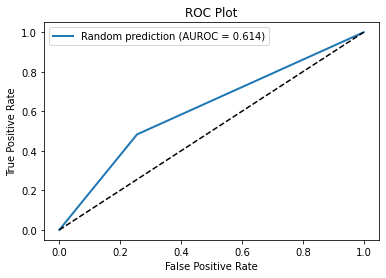

In [34]:
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

plt.plot(lr_fpr, lr_tpr,  linewidth=2, label='Random prediction (AUROC = %0.3f)' % lr_auc)
plt.plot([0,1], [0,1], 'k--')

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [35]:
print(f'Precision score: {precision_score(y_test, lr_probs)}')
print(f'Recall score: {recall_score(y_test, lr_probs)}')

Precision score: 0.6717325227963525
Recall score: 0.48323615160349853


With the high precision and lower recall score, this model reduces the number of false positives without reducing the number of false negatives. This allows us to be more confident that our model is correctly predicting bankruptcies, but comes with the price that it will return fewer results and miss classifications.

### Naive Bayes Model

In [36]:
# Set up model
nb = GaussianNB()
nb.fit(x_train, y_train)

# Get confusion matrix
y_pred3 = nb.predict(x_test)
cm = confusion_matrix(y_test, y_pred3)
print(f'Confusion matrix:\n {cm}')

Confusion matrix:
 [[1021  247]
 [ 775  597]]


In [37]:
# Check accuracy
acc3 = accuracy_score(y_test, y_pred3)
print(f'Accuracy score = {acc3}')
print(f'Classification Report {classification_report(y_test, y_pred3)}')

Accuracy score = 0.6128787878787879
Classification Report               precision    recall  f1-score   support

           0       0.57      0.81      0.67      1268
           1       0.71      0.44      0.54      1372

    accuracy                           0.61      2640
   macro avg       0.64      0.62      0.60      2640
weighted avg       0.64      0.61      0.60      2640



In [38]:
nb_probs = nb.predict_proba(x_test)
nb_auc = roc_auc_score(y_test, nb_probs[:, 1])
print('Prediction: AUROC = %.3f' % (nb_auc))

Prediction: AUROC = 0.707


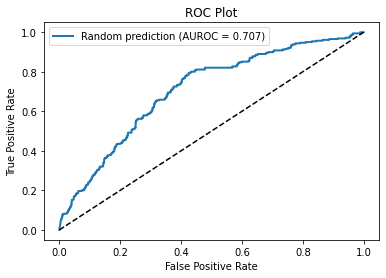

In [39]:
nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs[:,1])

plt.plot(nb_fpr, nb_tpr, linewidth=2, label='Random prediction (AUROC = %0.3f)' % nb_auc)
plt.plot([0,1], [0,1], 'k--')

# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [40]:
print(f'Precision score: {precision_score(y_test, y_pred3)}')
print(f'Recall score: {recall_score(y_test, y_pred3)}')

Precision score: 0.707345971563981
Recall score: 0.43513119533527694


## Conclusion
After performing an EDA, I was able to identify that the data set had several outliers and was unbalanced. These were addressed so that the noise can be limited in the data and passed through several different types of models. After analyzing the precision, recall, and accuracy scores, the model the performed the best was the SMV3 model where I tuned the C score to 2. Clarifying the C score helps the model avoid misclassifying variables, which improves overall accuracy.